<div class='alert alert-success'>
    <h1 align="center">Search Algorithms: Uninformed Search Strategies</h1> 
    <h3 align="center">Artificial Intelligece Course (Fall 2021)</h3>
    <h5 align="center">Seyed Naser RAZAVI <a href='http://www.snrazavi.ir/ai-slides/'>(website)</a></h5>
</div>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from collections import namedtuple

from utils import *
from npuzzle import NPuzzleState

## Uninformed Search Strategies: OOP implementation

In uniformed (blind) search strategies, we don't have any additional information other than the information provided in the problem formulation (states, actions, initial state and goal state(s)). 

Later you will see informed search strategis in which you have other information (heuristics) that during the search process guide you towards the goal state.

- BFS (Breadth First Search)
- UCS (Uniform Cost Search)
- DFS (Depth First Search)
- DLS (Depth Limitted Search)
- IDS (Iterative Deepening Search)

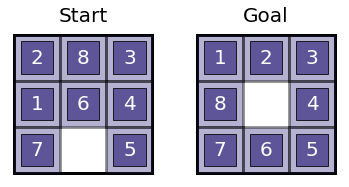

In [2]:
start_state_tiles = [
    2, 8, 3, 
    1, 6, 4, 
    7, 0, 5]

goal_state_tiles = [
    1, 2, 3, 
    8, 0, 4,
    7, 6, 5]

# define start state and goal state
start_state = NPuzzleState(tiles=start_state_tiles)
goal_state = NPuzzleState(tiles=goal_state_tiles)

# plot the start state and the goal state
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
start_state.plot(axes[0], 'Start')
goal_state.plot(axes[1], 'Goal')
plt.show()

### BFS
- Frontier is a FIFO list (or queue) and is implemented in the `utils.py`.

In [3]:
Node = namedtuple('Node', 'state parent action cost')


class BFS:
    ''' Breadth-First Search strategy'''
    
    def __init__(self):
        self.frontier = Queue()
        self.reached = set()
        self.num_generated = 0

        
    def search(self, start_state, goal_state):

        node = Node(start_state, None, None, 0)

        if start_state == goal_state:
            return solution(node)

        self.frontier.push(node)
        self.reached.add(start_state)


        while not self.frontier.is_empty():        
            # select a candidate node
            node = self.frontier.pop()

            # expand
            for successor, action, step_cost in node.state.successors():
                self.num_generated += 1

                if successor == goal_state:
                    return self._solution(Node(successor, node, action, node.cost + step_cost))

                if successor not in self.reached:
                    self.reached.add(successor)
                    self.frontier.push(Node(successor, node, action, node.cost + step_cost))

        return None  # if no solution found
    
    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Number of generated nodes: 70


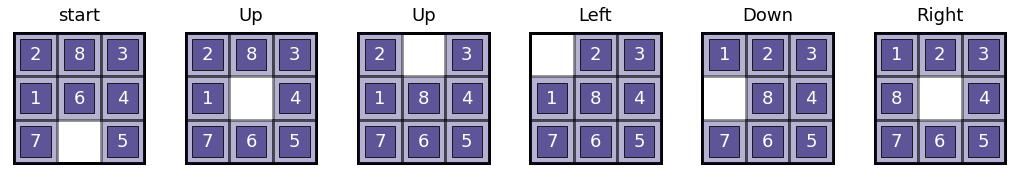

In [4]:
bfs = BFS()
solution_path = bfs.search(start_state, goal_state)

print(f"Number of generated nodes: {bfs.num_generated}")
show_solution(start_state, solution_path, ncols=6)

### Using `__call__()`

In [5]:
class BFS:
    ''' Breadth-First Search strategy'''
    
    def __init__(self):
        self.frontier = Queue()
        self.reached = set()
        self.num_generated = 0

        
    def search(self, start_state, goal_state):

        node = Node(start_state, None, None, 0)

        if start_state == goal_state:
            return solution(node)

        self.frontier.push(node)
        self.reached.add(start_state)


        while not self.frontier.is_empty():        
            # select a candidate node
            node = self.frontier.pop()

            # expand
            for successor, action, step_cost in node.state.successors():
                self.num_generated += 1

                if successor == goal_state:
                    return self._solution(Node(successor, node, action, node.cost + step_cost))

                if successor not in self.reached:
                    self.reached.add(successor)
                    self.frontier.push(Node(successor, node, action, node.cost + step_cost))

        return None  # if no solution found
    
    def __call__(self, start_state, goal_state):
        return self.search(start_state, goal_state)
    
    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Number of generated nodes: 70


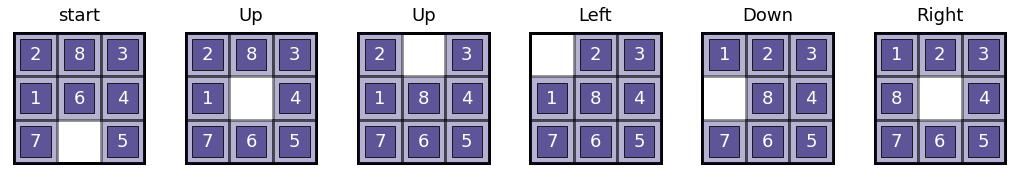

In [6]:
bfs = BFS()
solution_path = bfs(start_state, goal_state)

print(f"Number of generated nodes: {bfs.num_generated}")
show_solution(start_state, solution_path, ncols=6)

## UCS
- Frontier is a priority queue, in which nodes are sorted according to their path costs. 
- Again, the implementation of priority queue is given in the `utils.py`.

<img src='imgs/Best_First.png' width='80%'>

In [7]:
class UCS:
    '''Uniform Cost Search'''
    
    def __init__(self):
        self.frontier = PriorityQueue()
        self.reached = dict()  # a dictionary of (state, node)
        self.num_generated = 0
        
    def search(self, start_state, goal_state):

        node = Node(start_state, None, None, 0)
        self.frontier.push(node, 0)  # push node and its priority
        self.reached[start_state] = node

        while not self.frontier.is_empty():
            # select a candidate node
            node = self.frontier.pop()

            # goal test
            if node.state == goal_state:
                return self._solution(node)

            # expand        
            for successor, action, step_cost in node.state.successors():
                self.num_generated += 1
                path_cost = node.cost + step_cost

                if successor not in self.reached or path_cost < self.reached[successor].cost:
                    child_node = Node(successor, node, action, path_cost)
                    self.reached[successor] = child_node
                    self.frontier.push(child_node, path_cost)

        return None  # if no solution found
    
    def __call__(self, start_state, goal_state):
        return self.search(start_state, goal_state)
   
    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Number of generated nodes: 122


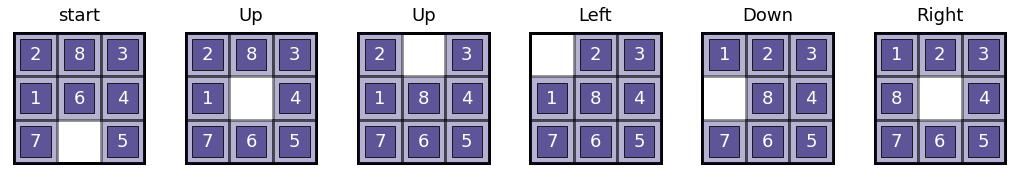

In [8]:
ucs = UCS()
solution_path = ucs(start_state, goal_state)

print(f"Number of generated nodes: {ucs.num_generated}")
show_solution(start_state, solution_path, ncols=6)

**Note**: that because in this problem, the cost of all the actions are equal, the UCS strategy is exactly the same as BFS strategy (the unoptimized version).

### DLS

<img src='imgs/DLS_IDS.png' width='80%'>

In [9]:
class DLS:
    '''Depth Limitted Search'''
    
    def __init__(self):
        self._initialize()
        
    def _initialize(self):
        self.frontier = Stack()
        self.num_generated = 0
        self.result = 'failure'

    def search(self, start_state, goal_state, limit=30):

        def is_cycle(node):
            state = node.state
            while node.parent is not None:
                if state == node.parent.state:
                    return True
                node = node.parent
            return False
        
        self._initialize()
        self.frontier.push(Node(start_state, None, None, 0))  # 0 is the depth of the start node

        while not self.frontier.is_empty():
            # select a candidate node
            node = self.frontier.pop()

            # goal test
            if node.state == goal_state: 
                return self._solution(node)

            # before expansion, check the depth limit
            if node.cost >= limit:
                self.result = 'cutoff'
            elif not is_cycle(node):
                # expand                
                for successor, action, step_cost in node.state.successors():
                    self.frontier.push(Node(successor, node, action, node.cost + step_cost))
                    self.num_generated += 1

        return self.result
    
    def __call__(self, start_state, goal_state, limit=30):
        return self.search(start_state, goal_state, limit)

    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Perform a depth limitted search with depth limit 15.

Number of generated nodes: 2347


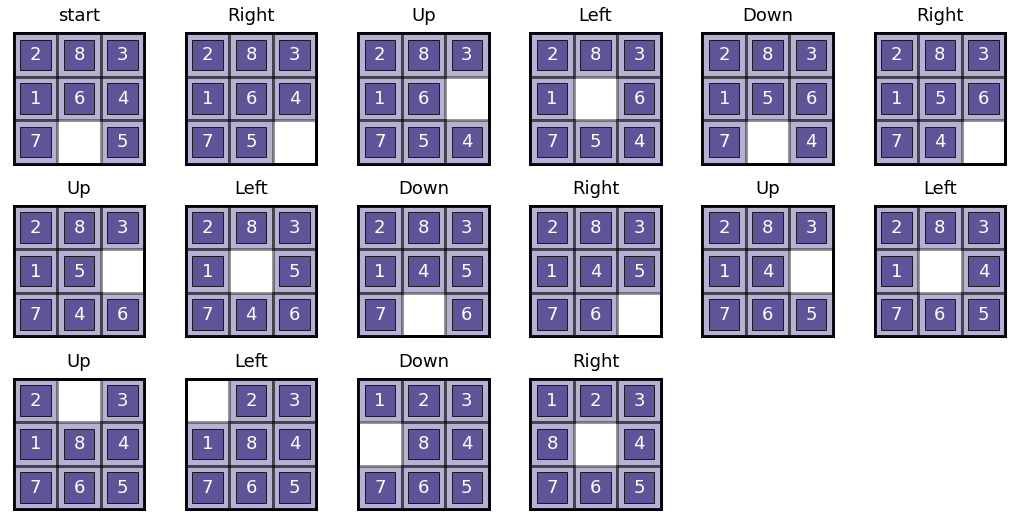

In [10]:
dls = DLS()
solution_path = dls(start_state, goal_state, limit=15)

print(f"Number of generated nodes: {dls.num_generated}")
show_solution(start_state, solution_path, ncols=6)

Perform a depth limitted search with depth limit 10.

Number of generated nodes: 823


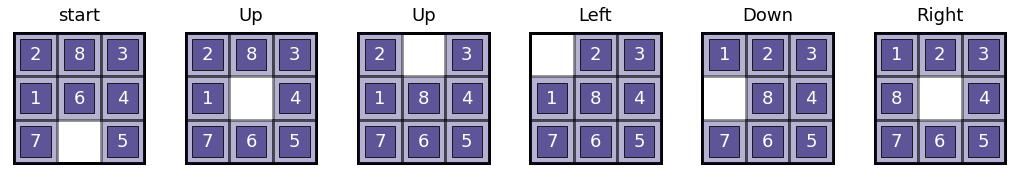

In [11]:
solution_path = dls(start_state, goal_state, limit=10)

print(f"Number of generated nodes: {dls.num_generated}")
show_solution(start_state, solution_path, ncols=6)

Perform a depth limitted search with depth limit 5.

Number of generated nodes: 56


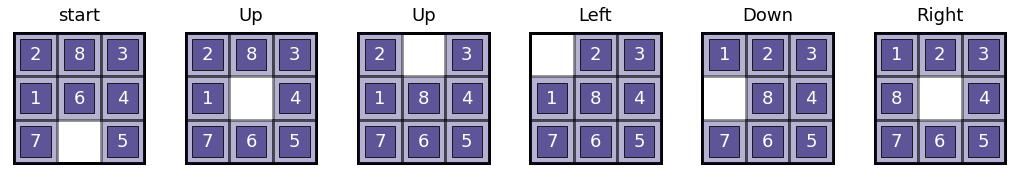

In [12]:
solution_path = dls(start_state, goal_state, limit=5)

print(f"Number of generated nodes: {dls.num_generated}")
show_solution(start_state, solution_path, ncols=6)

Perform a depth limitted search with depth limit 3.

In [13]:
solution_path = dls(start_state, goal_state, limit=3)

print(f"Number of generated nodes: {dls.num_generated}")
show_solution(start_state, solution_path, ncols=6)

Number of generated nodes: 26
No solution found!


### IDS

In [14]:
class IDS:
    '''Iterative Deepening Search'''
    
    def __init__(self):
        self.num_generated = 0
        self.dls = DLS()
    
    def search(self, start_state, goal_state):
        limit = 0

        while True:
            solution_path = self.dls(start_state, goal_state, limit)
            print(f'DLS (limit={limit}), number of generated nodes = {self.dls.num_generated:3d}')
            limit += 1
            self.num_generated += dls.num_generated

            if isinstance(solution_path, list):
                return solution_path
            
    def __call__(self, start_state, goal_state):
        return self.search(start_state, goal_state)

DLS (limit=0), number of generated nodes =   0
DLS (limit=1), number of generated nodes =   3
DLS (limit=2), number of generated nodes =  11
DLS (limit=3), number of generated nodes =  26
DLS (limit=4), number of generated nodes =  50
DLS (limit=5), number of generated nodes =  56
Total number of generated nodes: 156


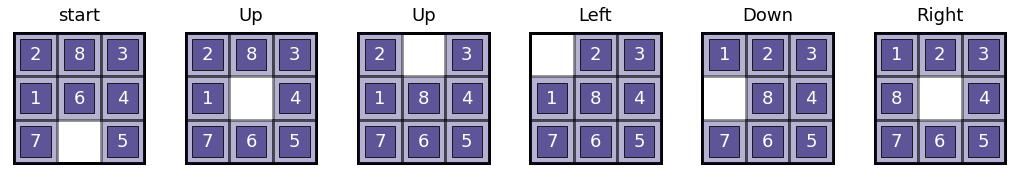

In [15]:
ids = IDS()
solution_path = ids(start_state, goal_state)

print(f"Total number of generated nodes: {ids.num_generated}")
show_solution(start_state, solution_path, ncols=6)

## Informed Search Strategies: OOP

In [16]:
def h1(state, goal):
    ''' Number of misplaced tiles heuristic
    '''
    return sum([state.tiles.index(tile) != goal.tiles.index(tile) 
                for tile in range(1, state.N + 1)])


def h2(state, goal):
    ''' Sum of manhatan distance heuristic
    '''
    return sum([manhatan_distance(tile, state, goal)
                for tile in range(1, state.N + 1)])

In [17]:
class Greedy:
    '''Greedy Search'''
    
    def __init__(self):
        self.num_generated = 0
        self.frontier = PriorityQueue()
        self.reached = dict()  # a dictionary of (state, node)

        
    def search(self, start_state, goal_state, heuristic):

        node = Node(start_state, None, None, 0) 
        self.frontier.push(node, heuristic(start_state, goal_state))
        self.reached[start_state] = node

        while not self.frontier.is_empty():
            # select a node
            node = self.frontier.pop()

            # goal test
            if node.state == goal_state:
                return self._solution(node)

            # expand
            for successor, action, step_cost in node.state.successors():
                self.num_generated += 1
                path_cost = node.cost + step_cost

                if successor not in self.reached or path_cost < self.reached[successor].cost:
                    child_node = Node(successor, node, action, path_cost)
                    self.reached[successor] = child_node
                    self.frontier.push(child_node, heuristic(successor, goal_state))

        return None  # no solution found
    
    def __call__(self, start_state, goal_state, heuristic):
        return self.search(start_state, goal_state, heuristic)

    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Number of generated nodes: 18


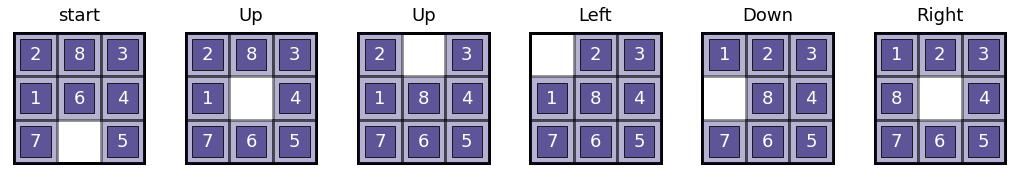

In [18]:
greedy = Greedy()
solution_path = greedy(start_state, goal_state, h1)

print(f"Number of generated nodes: {greedy.num_generated}")
show_solution(start_state, solution_path, ncols=6)

### A-Star

In [19]:
class AStar:
    '''A-Star Search'''
    
    def __init__(self):
        self.num_generated = 0
        self.frontier = PriorityQueue()
        self.reached = dict()  # a dictionary of (state, node)

    def search(self, start_state, goal_state, heuristic):
        node = Node(start_state, None, None, 0) 
        self.frontier.push(node, 0 + heuristic(start_state, goal_state))
        self.reached[start_state] = node

        while not self.frontier.is_empty():
            # select a node
            node = self.frontier.pop()

            # goal test
            if node.state == goal_state:
                return self._solution(node)

            # expand
            for successor, action, step_cost in node.state.successors():
                self.num_generated += 1
                path_cost = node.cost + step_cost

                if successor not in self.reached or path_cost < self.reached[successor].cost:
                    child_node = Node(successor, node, action, path_cost)
                    self.reached[successor] = child_node
                    self.frontier.push(child_node, path_cost + heuristic(successor, goal_state))

        return None  # no solution found
    
    def __call__(self, start_state, goal_state, heuristic):
        return self.search(start_state, goal_state, heuristic)

    @staticmethod
    def _solution(node):
        path = []
        while node.parent is not None:
            path = [(node.state, node.action)] + path
            node = node.parent
        return path

Number of generated nodes = 15


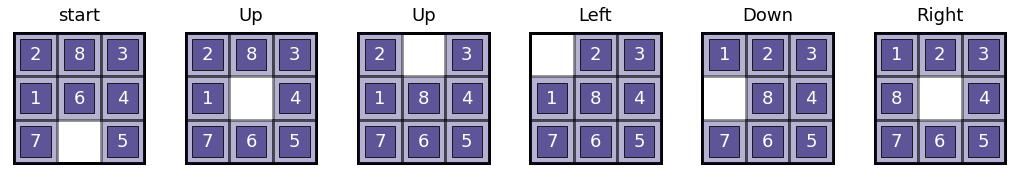

In [20]:
a_star = AStar()
path = a_star(start_state, goal_state, h2)

print(f"Number of generated nodes = {a_star.num_generated}")
show_solution(start_state, path, ncols=6)

### Solving a hard case
- Solving a typical instance of the 8-puzzle. 
- The shortest solution is 26 actions long.

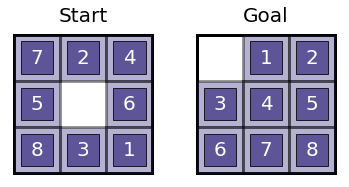

In [21]:
start_state_tiles = [
    7, 2, 4, 
    5, 0, 6, 
    8, 3, 1]

goal_state_tiles = [
    0, 1, 2, 
    3, 4, 5, 
    6, 7, 8] 

# define start state and goal state
start_state = NPuzzleState(tiles=start_state_tiles)
goal_state = NPuzzleState(tiles=goal_state_tiles)

# plot the start state and the goal state
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
start_state.plot(axes[0], 'Start')
goal_state.plot(axes[1], 'Goal')
plt.show()

Number of generated nodes = 10644


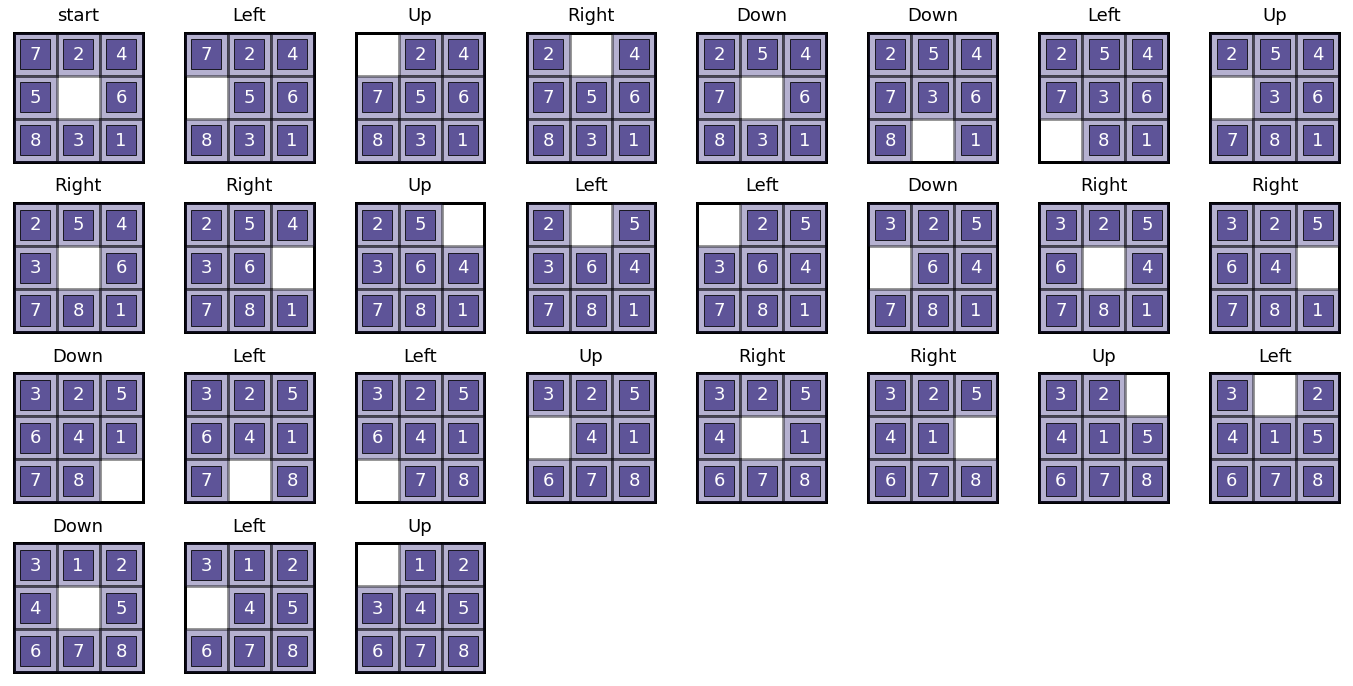

In [22]:
a_star = AStar()
path = a_star(start_state, goal_state, h2)

print(f"Number of generated nodes = {a_star.num_generated}")
show_solution(start_state, path, ncols=8)

## What is next?
- So far, we have solved problems in which the aim is to find a path from an initial state to a goal state. 
- However, in many real world problems, the aim is to find a single state (not a solution path) which is an optimal (or good) state, in terms of some criteria.
- For example in schedling problem, the goal is to find a schedule which satisfies some certain criteria. Here the import thing is the schedule itself not the path which leads to that schedule.
- In the next lesson, we will explore some local search strategies which are used to solve these kinds of problems.